Sirisha Ginnu

Using device: cuda
Classes: ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
Number of classes: 11


/home/ubuntu/nlpvinn/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/ubuntu/nlpvinn/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/home/ubuntu/nlpvinn/lib/python3.12/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(
/tmp/ipykernel_7157/2791961629.py:76: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)

Epoch 1/8, Train Loss: 1.9199, Val Loss: 1.5934
Epoch 2/8, Train Loss: 1.6826, Val Loss: 1.4582
Epoch 3/8, Train Loss: 1.5545, Val Loss: 1.3547
Epoch 4/8, Train Loss: 1.4673, Val Loss: 1.3552
Epoch 5/8, Train Loss: 1.3634, Val Loss: 1.4001
Epoch 6/8, Train Loss: 1.2986, Val Loss: 1.1579
Epoch 7/8, Train Loss: 1.2369, Val Loss: 1.2200
Epoch 8/8, Train Loss: 1.2010, Val Loss: 1.0093


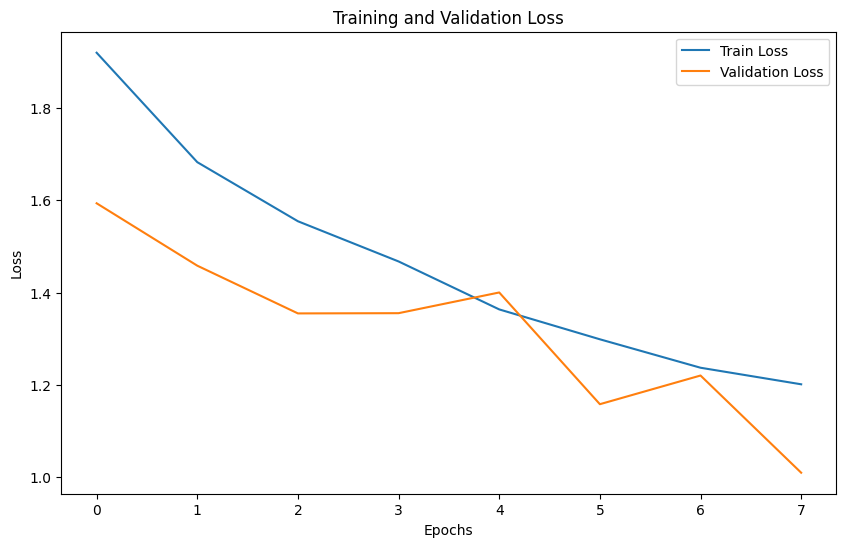

Validation Accuracy: 65.70%


In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.models import resnet34
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data Preparation (Ensure the dataset path is correct)
root_path = '/home/ubuntu/Siri_ML_Proj/dataset'  # Replace with your dataset path

if not os.path.exists(root_path) or len(os.listdir(root_path)) == 0:
    raise ValueError(f"The dataset folder '{root_path}' is empty or does not exist. Please check your dataset.")

# Define transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(20, shear=10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for ResNet models
])

# Load the dataset using ImageFolder (expects subfolders named after class labels)
dataset = torchvision.datasets.ImageFolder(root=root_path, transform=transform)

# Split dataset into training and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for training and validation sets
batch_size = 8  # Reduced batch size to save memory
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Print class names and distribution
class_names = dataset.classes
print(f"Classes: {class_names}")
print(f"Number of classes: {len(class_names)}")

# **Model Definition**
model = resnet34(pretrained=True)  # Use ResNet34 instead of ResNet50 for lower memory usage
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, len(class_names))  # Output layer for number of classes
)

# Clear unused memory before moving model to GPU
torch.cuda.empty_cache()

# Move model to device
model = model.to(device)

# **Loss Function and Optimizer**
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)  # Weight decay for regularization

# Learning rate scheduler
scheduler = ReduceLROnPlateau(optimizer, 'min', patience=2, verbose=True)

# Enable mixed precision training
scaler = GradScaler()

# **Training Function with Learning Rate Scheduler**
def train_model(model, train_loader, val_loader, criterion, optimizer, scaler, scheduler, num_epochs=20):
    train_loss_history = []
    val_loss_history = []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            # Mixed precision training with autocast
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            # Scale loss and backpropagate
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

        train_loss_history.append(running_loss / len(train_loader))

        # Validation phase
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_loss_history.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}")

        # Save the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')

        # Step scheduler
        scheduler.step(val_loss)

    return train_loss_history, val_loss_history

# **Train the Model**
num_epochs = 8  # Increased the number of epochs
train_loss_history, val_loss_history = train_model(model, train_loader, val_loader,
                                                   criterion, optimizer, scaler, scheduler,
                                                   num_epochs)

# **Plot Training and Validation Loss**
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# **Evaluation on Validation Set**
def evaluate_model(model, loader):
    model.eval()
    correct_predictions = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct_predictions += (preds == labels).sum().item()

    accuracy = correct_predictions / len(loader.dataset) * 100
    return accuracy

val_accuracy = evaluate_model(model, val_loader)
print(f"Validation Accuracy: {val_accuracy:.2f}%")


Using device: cuda
Classes: ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
Number of classes: 11


/tmp/ipykernel_9980/3349609692.py:78: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_9980/3349609692.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/20, Train Loss: 1.5398, Val Loss: 1.4179
Epoch 2/20, Train Loss: 1.2308, Val Loss: 1.7342
Epoch 3/20, Train Loss: 1.1456, Val Loss: 1.0243
Epoch 4/20, Train Loss: 1.0186, Val Loss: 0.8426
Epoch 5/20, Train Loss: 0.9252, Val Loss: 0.8333
Epoch 6/20, Train Loss: 0.8420, Val Loss: 0.6832
Epoch 7/20, Train Loss: 0.7555, Val Loss: 0.6623
Epoch 8/20, Train Loss: 0.6833, Val Loss: 0.5858
Epoch 9/20, Train Loss: 0.6359, Val Loss: 0.5422
Epoch 10/20, Train Loss: 0.5763, Val Loss: 0.5592
Epoch 11/20, Train Loss: 0.5568, Val Loss: 0.4856
Epoch 12/20, Train Loss: 0.5671, Val Loss: 0.4877
Epoch 13/20, Train Loss: 0.5599, Val Loss: 0.5341
Epoch 14/20, Train Loss: 0.5991, Val Loss: 0.5363
Epoch 15/20, Train Loss: 0.6403, Val Loss: 0.8347
Epoch 16/20, Train Loss: 0.7084, Val Loss: 0.6039
Epoch 17/20, Train Loss: 0.7465, Val Loss: 0.7261
Epoch 18/20, Train Loss: 0.7820, Val Loss: 0.7985
Epoch 19/20, Train Loss: 0.7656, Val Loss: 0.7507
Epoch 20/20, Train Loss: 0.7820, Val Loss: 0.7412


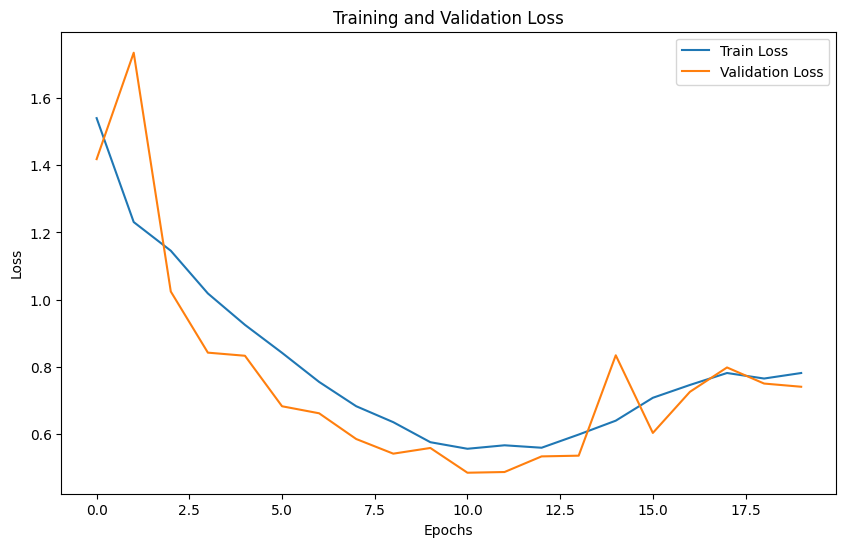

Validation Accuracy: 75.31%


In [ ]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.models import resnet50  # Using ResNet50
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
from torch.utils.data import DataLoader

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data Preparation (Ensure the dataset path is correct)
root_path = '/home/ubuntu/Siri_ML_Proj/dataset'  # Replace with your dataset path

if not os.path.exists(root_path) or len(os.listdir(root_path)) == 0:
    raise ValueError(f"The dataset folder '{root_path}' is empty or does not exist. Please check your dataset.")

# Define transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(20, shear=10),
    transforms.RandomResizedCrop(224),  # Added random resized crop
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for ResNet models
])

# Load the dataset using ImageFolder (expects subfolders named after class labels)
dataset = torchvision.datasets.ImageFolder(root=root_path, transform=transform)

# Split dataset into training and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for training and validation sets
batch_size = 16  # Increased batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Print class names and distribution
class_names = dataset.classes
print(f"Classes: {class_names}")
print(f"Number of classes: {len(class_names)}")

# **Model Definition**
model = resnet50(pretrained=True)  # Using ResNet50
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, len(class_names))  # Output layer for number of classes
)

# Clear unused memory before moving model to GPU
torch.cuda.empty_cache()

# Move model to device
model = model.to(device)

# **Loss Function and Optimizer**
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Reduced learning rate and added weight decay

# Learning rate scheduler (Cosine Annealing)
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

# Enable mixed precision training
scaler = GradScaler()

# **Training Function with Learning Rate Scheduler**
def train_model(model, train_loader, val_loader, criterion, optimizer, scaler, scheduler, num_epochs=20):
    train_loss_history = []
    val_loss_history = []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            # Mixed precision training with autocast
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            # Scale loss and backpropagate
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

        train_loss_history.append(running_loss / len(train_loader))

        # Validation phase
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_loss_history.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}")

        # Save the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')

        # Step scheduler
        scheduler.step()

    return train_loss_history, val_loss_history

# **Train the Model**
num_epochs = 20 # Increased the number of epochs for more training
train_loss_history, val_loss_history = train_model(model, train_loader, val_loader,
                                                   criterion, optimizer, scaler, scheduler,
                                                   num_epochs)

# **Plot Training and Validation Loss**
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# **Evaluation on Validation Set**
def evaluate_model(model, loader):
    model.eval()
    correct_predictions = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct_predictions += (preds == labels).sum().item()

    accuracy = correct_predictions / len(loader.dataset) * 100
    return accuracy

val_accuracy = evaluate_model(model, val_loader)
print(f"Validation Accuracy: {val_accuracy:.2f}%")


Using device: cuda
Classes: ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
Number of classes: 11


/tmp/ipykernel_9980/236833790.py:78: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_9980/236833790.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/12, Train Loss: 1.5663, Val Loss: 1.4204
Epoch 2/12, Train Loss: 1.2742, Val Loss: 1.2043
Epoch 3/12, Train Loss: 1.1086, Val Loss: 0.9783
Epoch 4/12, Train Loss: 1.0172, Val Loss: 0.9770
Epoch 5/12, Train Loss: 0.9104, Val Loss: 0.7456
Epoch 6/12, Train Loss: 0.8116, Val Loss: 0.6524
Epoch 7/12, Train Loss: 0.7493, Val Loss: 0.6837
Epoch 8/12, Train Loss: 0.6500, Val Loss: 0.5352
Epoch 9/12, Train Loss: 0.6191, Val Loss: 0.4810
Epoch 10/12, Train Loss: 0.5735, Val Loss: 0.4920
Epoch 11/12, Train Loss: 0.5571, Val Loss: 0.4788
Epoch 12/12, Train Loss: 0.5731, Val Loss: 0.4141


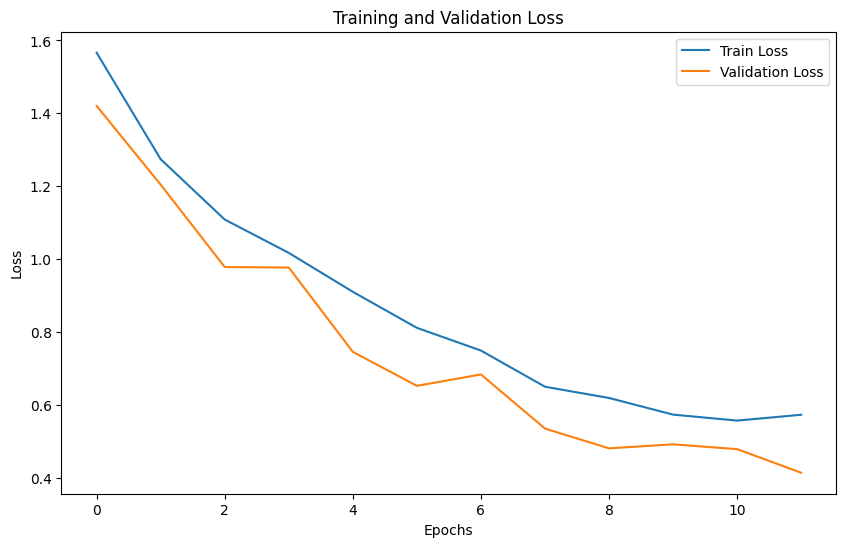

Validation Accuracy: 86.23%


In [4]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.models import resnet50  # Using ResNet50
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
from torch.utils.data import DataLoader

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data Preparation (Ensure the dataset path is correct)
root_path = '/home/ubuntu/Siri_ML_Proj/dataset'  # Replace with your dataset path

if not os.path.exists(root_path) or len(os.listdir(root_path)) == 0:
    raise ValueError(f"The dataset folder '{root_path}' is empty or does not exist. Please check your dataset.")

# Define transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(20, shear=10),
    transforms.RandomResizedCrop(224),  # Added random resized crop
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for ResNet models
])

# Load the dataset using ImageFolder (expects subfolders named after class labels)
dataset = torchvision.datasets.ImageFolder(root=root_path, transform=transform)

# Split dataset into training and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for training and validation sets
batch_size = 16  # Increased batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Print class names and distribution
class_names = dataset.classes
print(f"Classes: {class_names}")
print(f"Number of classes: {len(class_names)}")

# **Model Definition**
model = resnet50(pretrained=True)  # Using ResNet50
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, len(class_names))  # Output layer for number of classes
)

# Clear unused memory before moving model to GPU
torch.cuda.empty_cache()

# Move model to device
model = model.to(device)

# **Loss Function and Optimizer**
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Reduced learning rate and added weight decay

# Learning rate scheduler (Cosine Annealing)
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

# Enable mixed precision training
scaler = GradScaler()

# **Training Function with Learning Rate Scheduler**
def train_model(model, train_loader, val_loader, criterion, optimizer, scaler, scheduler, num_epochs=20):
    train_loss_history = []
    val_loss_history = []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            # Mixed precision training with autocast
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            # Scale loss and backpropagate
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

        train_loss_history.append(running_loss / len(train_loader))

        # Validation phase
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_loss_history.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}")

        # Save the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')

        # Step scheduler
        scheduler.step()

    return train_loss_history, val_loss_history

# **Train the Model**
num_epochs = 12 # Increased the number of epochs for more training
train_loss_history, val_loss_history = train_model(model, train_loader, val_loader,
                                                   criterion, optimizer, scaler, scheduler,
                                                   num_epochs)

# **Plot Training and Validation Loss**
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# **Evaluation on Validation Set**
def evaluate_model(model, loader):
    model.eval()
    correct_predictions = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct_predictions += (preds == labels).sum().item()

    accuracy = correct_predictions / len(loader.dataset) * 100
    return accuracy

val_accuracy = evaluate_model(model, val_loader)
print(f"Validation Accuracy: {val_accuracy:.2f}%")


Using device: cuda
Classes: ['dew', 'fogsmog', 'frost', 'glaze', 'hail', 'lightning', 'rain', 'rainbow', 'rime', 'sandstorm', 'snow']
Number of classes: 11


/tmp/ipykernel_9980/1546216848.py:78: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = GradScaler()
/tmp/ipykernel_9980/1546216848.py:96: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with autocast():


Epoch 1/14, Train Loss: 1.5908, Val Loss: 1.1883
Epoch 2/14, Train Loss: 1.2938, Val Loss: 1.0358
Epoch 3/14, Train Loss: 1.1632, Val Loss: 0.9398
Epoch 4/14, Train Loss: 1.0813, Val Loss: 0.9306
Epoch 5/14, Train Loss: 0.9668, Val Loss: 0.9089
Epoch 6/14, Train Loss: 0.8985, Val Loss: 0.6898
Epoch 7/14, Train Loss: 0.8045, Val Loss: 0.7053
Epoch 8/14, Train Loss: 0.7297, Val Loss: 0.5682
Epoch 9/14, Train Loss: 0.6384, Val Loss: 0.5105
Epoch 10/14, Train Loss: 0.6319, Val Loss: 0.5259
Epoch 11/14, Train Loss: 0.6289, Val Loss: 0.5365
Epoch 12/14, Train Loss: 0.6152, Val Loss: 0.4938
Epoch 13/14, Train Loss: 0.6302, Val Loss: 0.4893
Epoch 14/14, Train Loss: 0.6667, Val Loss: 0.5275


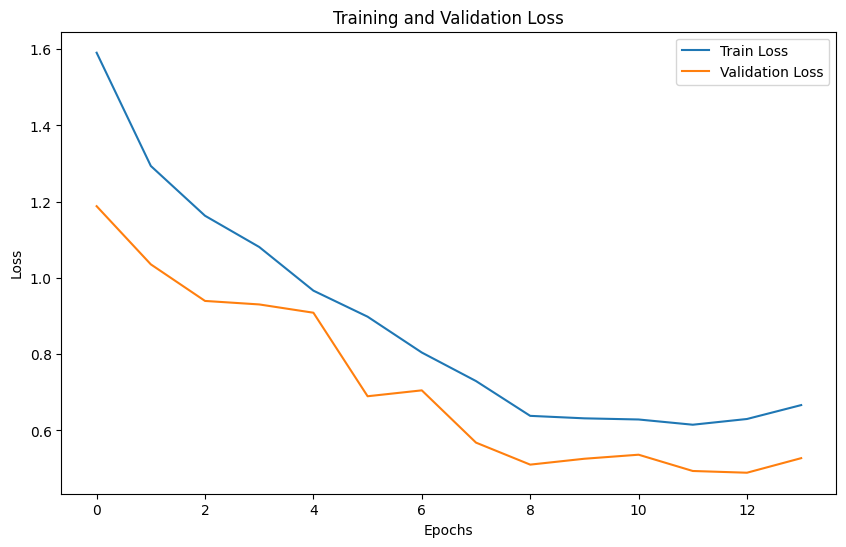

Validation Accuracy: 82.88%


In [5]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchvision.models import resnet50  # Using ResNet50
from torch.cuda.amp import GradScaler, autocast
import matplotlib.pyplot as plt
from torch.optim.lr_scheduler import ReduceLROnPlateau, CosineAnnealingLR
from torch.utils.data import DataLoader

# Check for GPU availability
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Data Preparation 
root_path = '/home/ubuntu/Siri_ML_Proj/dataset'  

if not os.path.exists(root_path) or len(os.listdir(root_path)) == 0:
    raise ValueError(f"The dataset folder '{root_path}' is empty or does not exist. Please check your dataset.")

# Define transformations for data augmentation and normalization
transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(20),
    transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    transforms.RandomAffine(20, shear=10),
    transforms.RandomResizedCrop(224),  # Added random resized crop
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  # Normalization for ResNet models
])

# Load the dataset using ImageFolder (expects subfolders named after class labels)
dataset = torchvision.datasets.ImageFolder(root=root_path, transform=transform)

# Split dataset into training and validation sets (80% train, 20% validation)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create DataLoaders for training and validation sets
batch_size = 16  # Increased batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size)

# Print class names and distribution
class_names = dataset.classes
print(f"Classes: {class_names}")
print(f"Number of classes: {len(class_names)}")

# **Model Definition**
model = resnet50(pretrained=True)  # Using ResNet50
num_features = model.fc.in_features
model.fc = nn.Sequential(
    nn.Linear(num_features, 256),
    nn.ReLU(),
    nn.Dropout(0.5),
    nn.Linear(256, len(class_names))  # Output layer for number of classes
)

# Clear unused memory before moving model to GPU
torch.cuda.empty_cache()

# Move model to device
model = model.to(device)

# **Loss Function and Optimizer**
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.0005, weight_decay=1e-4)  # Reduced learning rate and added weight decay

# Learning rate scheduler (Cosine Annealing)
scheduler = CosineAnnealingLR(optimizer, T_max=10, eta_min=1e-6)

# Enable mixed precision training
scaler = GradScaler()

# **Training Function with Learning Rate Scheduler**
def train_model(model, train_loader, val_loader, criterion, optimizer, scaler, scheduler, num_epochs=20):
    train_loss_history = []
    val_loss_history = []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)
            
            optimizer.zero_grad()
            
            # Mixed precision training with autocast
            with autocast():
                outputs = model(inputs)
                loss = criterion(outputs, labels)

            # Scale loss and backpropagate
            scaler.scale(loss).backward()
            scaler.step(optimizer)
            scaler.update()

            running_loss += loss.item()

        train_loss_history.append(running_loss / len(train_loader))

        # Validation phase
        model.eval()
        val_loss = 0.0

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        val_loss_history.append(val_loss)

        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {running_loss / len(train_loader):.4f}, Val Loss: {val_loss:.4f}")

        # Save the best model based on validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), 'best_model.pth')

        # Step scheduler
        scheduler.step()

    return train_loss_history, val_loss_history

# **Train the Model**
num_epochs = 14 # Increased the number of epochs for more training
train_loss_history, val_loss_history = train_model(model, train_loader, val_loader,
                                                   criterion, optimizer, scaler, scheduler,
                                                   num_epochs)

# **Plot Training and Validation Loss**
plt.figure(figsize=(10, 6))
plt.plot(train_loss_history, label='Train Loss')
plt.plot(val_loss_history, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss')
plt.legend()
plt.show()

# **Evaluation on Validation Set**
def evaluate_model(model, loader):
    model.eval()
    correct_predictions = 0

    with torch.no_grad():
        for inputs, labels in loader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            correct_predictions += (preds == labels).sum().item()

    accuracy = correct_predictions / len(loader.dataset) * 100
    return accuracy

val_accuracy = evaluate_model(model, val_loader)
print(f"Validation Accuracy: {val_accuracy:.2f}%")
